# Librerías

In [27]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict


import pandas as pd
import numpy as np
import joblib
import os
from google.colab import drive
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


from sklearn.pipeline import Pipeline
import warnings
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
# 1. Importaciones necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Cargar datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Definimos la ruta de la carpeta
folder_path = '/content/drive/MyDrive/Trabajo_final_promidat/'

# Listar archivos para verificar (opcional, pero ayuda a evitar errores de dedo)
print("Archivos en la carpeta:", os.listdir(folder_path))

# Cargar el dataset
df_clasificador = pd.read_csv(folder_path + 'df_clasificador.csv')

# Mostrar las primeras filas y estructura
print("\nEstructura del dataset:")
print(df_clasificador.info())
df_clasificador.head()

Archivos en la carpeta: ['mejor_modelo_clasificador_f1macro.pkl', 'modelo_FINAL_16vars_SVC_Optimizado.pkl', 'modelo_FINAL_14vars_GOLD.pkl', 'df_clasificador.csv', 'Modelo_final_StandarScaler.pkl', 'Modelo_final_StandarScaler_CV3.pkl', 'Modelo_final_StandarScaler_ULTRA_PRO_MAX.pkl', 'df_clasificador_15.csv', 'Modelo_final_GRID_SEARCH.pkl', 'Modelo_final_GRID_SEARCH_2.pkl', 'Modelo_final_GRID_SEARCH_3.pkl', 'Modelo_SUICIDIO_FINAL.pkl']

Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIS_Roberts             226 non-null    int64 
 1   salud_fisica            226 non-null    int64 
 2   ocultar_emociones       226 non-null    int64 
 3   dificultad_pedir_ayuda  226 non-null    int64 
 4   guarda_sentimientos     226 non-null    int64 
 5   sin_motivacion          226 non-null    int64 
 6   preocupado 

,EIS_Roberts,salud_fisica,ocultar_emociones,dificultad_pedir_ayuda,guarda_sentimientos,sin_motivacion,preocupado,sin_proposito,no_reconocer_logros,incapaz_solucionar,intento_autolesion,plan_autolesion,autolesion_fisica,soledad,dificultad_economica,cluster
0,0,3,4,2,1,0,1,0,0,0,0,0,0,0,1,No Riesgo
1,0,3,1,2,1,0,2,0,2,1,0,0,0,0,3,No Riesgo
2,0,1,0,2,2,0,1,0,0,0,0,0,0,0,0,No Riesgo
3,9,3,5,5,6,4,6,6,4,6,6,6,4,4,6,Externalizante
4,0,4,3,3,4,0,2,0,0,0,0,0,0,1,3,No Riesgo


In [4]:
mapa_cluster = {
    'No Riesgo': 0,
    'Internalizante': 1,
    'Externalizante': 2
}

df_clasificador['cluster'] = df_clasificador['cluster'].map(mapa_cluster)
df_clasificador['cluster']

,cluster
0,0
1,0
2,0
3,2
4,0
...,...
221,1
222,1
223,1
224,0


# Pipe

In [5]:
# Definir X e y
X = df_clasificador.drop('cluster', axis=1)
y = df_clasificador['cluster']

In [6]:
print(f"\nDistribución de clases:")
print(y.value_counts())
print(f"\nTotal de observaciones: {len(y)}")
print(f"Total de variables: {X.shape[1]}")


Distribución de clases:
cluster
0    147
1     72
2      7
Name: count, dtype: int64

Total de observaciones: 226
Total de variables: 15


In [7]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('algoritmo', LogisticRegression())
])

In [8]:
# Definición del grid corregido
grid = [
    {   'scaler': [StandardScaler()],
        'algoritmo': [LogisticRegression()],
        'algoritmo__penalty': ['l1', 'l2'],
        'algoritmo__solver': ['liblinear', 'saga'], # Solvers que aceptan l1 y l2
        'algoritmo__C': [0.01, 0.1, 1, 10],
        'algoritmo__max_iter': [100, 250, 500, 1000], # Aquí volvemos a tus valores
        'algoritmo__class_weight': [None, 'balanced']
    },

    {   'scaler': [StandardScaler()],
        'algoritmo': [LogisticRegression()],
        'algoritmo__penalty': ['l2'],
        'algoritmo__solver': ['lbfgs', 'newton-cg'], # Estos solo aceptan L2
        'algoritmo__C': [0.01, 0.1, 1, 10],
        'algoritmo__max_iter': [100, 250, 500, 1000],
        'algoritmo__class_weight': [None, 'balanced']
    },

    {   'scaler': [StandardScaler()],
        'algoritmo': [LogisticRegression()],
        'algoritmo__penalty': ['elasticnet'],
        'algoritmo__solver': ['saga'],
        'algoritmo__l1_ratio': [0.1, 0.5, 0.9],
        'algoritmo__C': [0.01, 0.1, 1, 10],
        'algoritmo__max_iter': [1000, 2000],
        'algoritmo__class_weight': [None, 'balanced']
    },
    {   'scaler': ['passthrough'],
        'algoritmo': [DecisionTreeClassifier()],
        'algoritmo__criterion': ['gini', 'entropy'],
        'algoritmo__max_depth': [3, 5, 10, 15],
        'algoritmo__min_samples_split': [2, 5, 10],
        'algoritmo__min_samples_leaf': [1, 2, 4]

    },
    {   'scaler': ['passthrough'],
        'algoritmo': [RandomForestClassifier()],
        'algoritmo__n_estimators': [100, 200, 500],
        'algoritmo__criterion': ['gini', 'entropy'],
        'algoritmo__max_depth': [3, 5, 10, 15],
        'algoritmo__class_weight': ['balanced', 'balanced_subsample']
    },
    {   'scaler': ['passthrough'],
        'algoritmo': [XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss')],
        'algoritmo__n_estimators': [100, 200, 500],
        'algoritmo__learning_rate': [0.01, 0.1, 0.3],
        'algoritmo__max_depth': [2, 3, 4, 5, 6, 8, 10],
        'algoritmo__min_child_weight': [1, 5, 10],
        'algoritmo__subsample': [0.6, 0.8, 1.0],
        'algoritmo__gamma': [0, 0.1, 0.3],
        'algoritmo__colsample_bytree': [0.7, 0.8, 1.0], # Ajustado para 17 variables
        'algoritmo__reg_alpha': [0, 0.1, 0.5, 1],      # Cambiado None por 0
        'algoritmo__reg_lambda': [0.01, 0.1, 1, 2],    # Cambiado None por 1 (default)
    },
    {    'scaler': [StandardScaler()],
        'algoritmo': [KNeighborsClassifier()],
        'algoritmo__n_neighbors': [3, 5, 7, 10],
        'algoritmo__weights': ['uniform', 'distance'],
        'algoritmo__algorithm': ['auto'],
        'algoritmo__leaf_size': [10, 30, 50],
        'algoritmo__p': [1, 2, 3],
        'algoritmo__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']
    },
      { 'scaler': [StandardScaler()],
        'algoritmo': [SVC(probability=True)], # Importante para análisis posteriores
        'algoritmo__C': [0.1, 1, 10, 20],
        'algoritmo__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'algoritmo__degree': [2, 3, 4], # Grado 5 suele ser demasiado ruido para N=219
        'algoritmo__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'algoritmo__tol': [1e-3, 1e-4],
        'algoritmo__max_iter': [5000], # Suficiente para que converja en tu dataset
        'algoritmo__class_weight': ['balanced']
    },
    {   'scaler': [StandardScaler()],
        'algoritmo': [GaussianNB()],
        'algoritmo__var_smoothing': [1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
    }
]

# Validación cruzada

In [12]:
# Loop INTERNO: selección de hiperparámetros
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)

# Loop EXTERNO: estimación honesta del desempeño
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10)

# Objeto de búsqueda SIN fitear
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=grid,
    n_iter=500,
    cv=inner_cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0,
    error_score=np.nan
)

# Nested CV: en cada fold externo, search busca hiperparámetros
# SOLO con los datos de entrenamiento de ese fold
print("Iniciando Nested Cross-Validation...")
nested_scores = cross_validate(
    search, X, y,
    cv=outer_cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_estimator=True  # guarda el mejor modelo de cada fold
)

print(f"\nF1-Macro Nested CV: {nested_scores['test_score'].mean():.4f} ± {nested_scores['test_score'].std():.4f}")
print(f"Rango: [{nested_scores['test_score'].min():.4f}, {nested_scores['test_score'].max():.4f}]")

Iniciando Nested Cross-Validation...

F1-Macro Nested CV: 0.9260 ± 0.0525
Rango: [0.7903, 0.9895]


## Entrenamiento

In [13]:
# Ahora SÍ ajustamos con TODOS los datos para obtener el modelo final
print("Entrenando modelo definitivo con todos los datos...")
search_final = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=grid,
    n_iter=2000,
    cv=inner_cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    error_score=np.nan,
    random_state=42
)
search_final.fit(X, y)

best_model = search_final.best_estimator_

print(f"\nMejor F1-Macro (CV interna): {search_final.best_score_:.4f}")
print(f"Mejores Parámetros: {search_final.best_params_}")

Entrenando modelo definitivo con todos los datos...
Fitting 6 folds for each of 2000 candidates, totalling 12000 fits

Mejor F1-Macro (CV interna): 0.9743
Mejores Parámetros: {'scaler': StandardScaler(), 'algoritmo__tol': 0.001, 'algoritmo__max_iter': 5000, 'algoritmo__kernel': 'rbf', 'algoritmo__gamma': 0.001, 'algoritmo__degree': 4, 'algoritmo__class_weight': 'balanced', 'algoritmo__C': 10, 'algoritmo': SVC(probability=True)}


# Reporte de clasificación

In [14]:
# cross_val_predict para inspección visual (NO es la métrica oficial)
cv_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
y_pred_cv = cross_val_predict(best_model, X, y, cv=cv_simple, n_jobs=-1)

print("--- REPORTE DE CLASIFICACIÓN (inspección visual) ---")
print("NOTA: La métrica oficial es el Nested CV del paso anterior.\n")
print(classification_report(y, y_pred_cv,
      target_names=['No Riesgo', 'Internalizante', 'Externalizante']))

--- REPORTE DE CLASIFICACIÓN (inspección visual) ---
NOTA: La métrica oficial es el Nested CV del paso anterior.

                precision    recall  f1-score   support

     No Riesgo       0.98      0.96      0.97       147
Internalizante       0.92      0.96      0.94        72
Externalizante       1.00      1.00      1.00         7

      accuracy                           0.96       226
     macro avg       0.97      0.97      0.97       226
  weighted avg       0.96      0.96      0.96       226



# Matriz de confusión

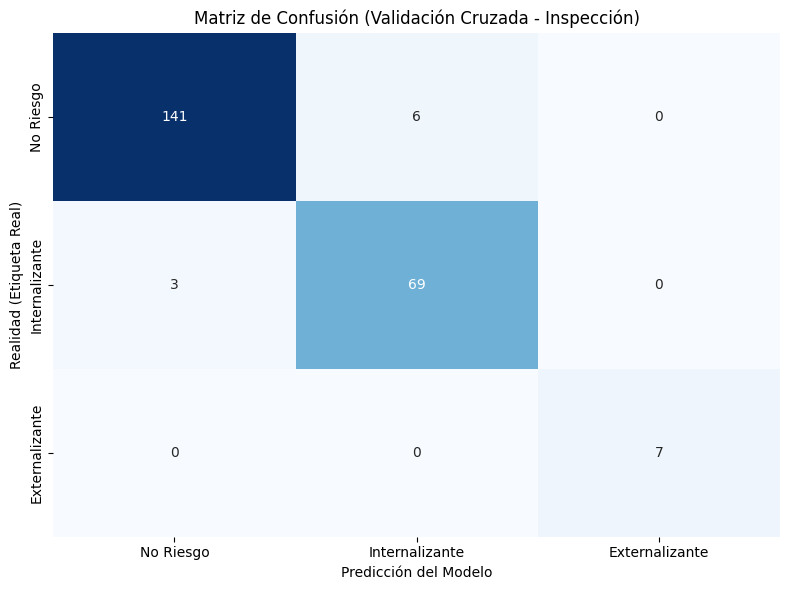

In [15]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred_cv)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Riesgo', 'Internalizante', 'Externalizante'],
            yticklabels=['No Riesgo', 'Internalizante', 'Externalizante'])
plt.title('Matriz de Confusión (Validación Cruzada - Inspección)')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad (Etiqueta Real)')
plt.tight_layout()
plt.show()

# Modelo Ganador

In [16]:
print("MODELO GANADOR")
print("-" * 40)
ganador = best_model.named_steps['algoritmo']
print(f"Algoritmo: {type(ganador).__name__}")
print(f"Hiperparámetros:\n{ganador.get_params()}")

MODELO GANADOR
----------------------------------------
Algoritmo: SVC
Hiperparámetros:
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 4, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': 5000, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


# Importancia de las variables

Analizando importancia de variables...


/tmp/ipython-input-3511362347.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancia, palette='viridis')


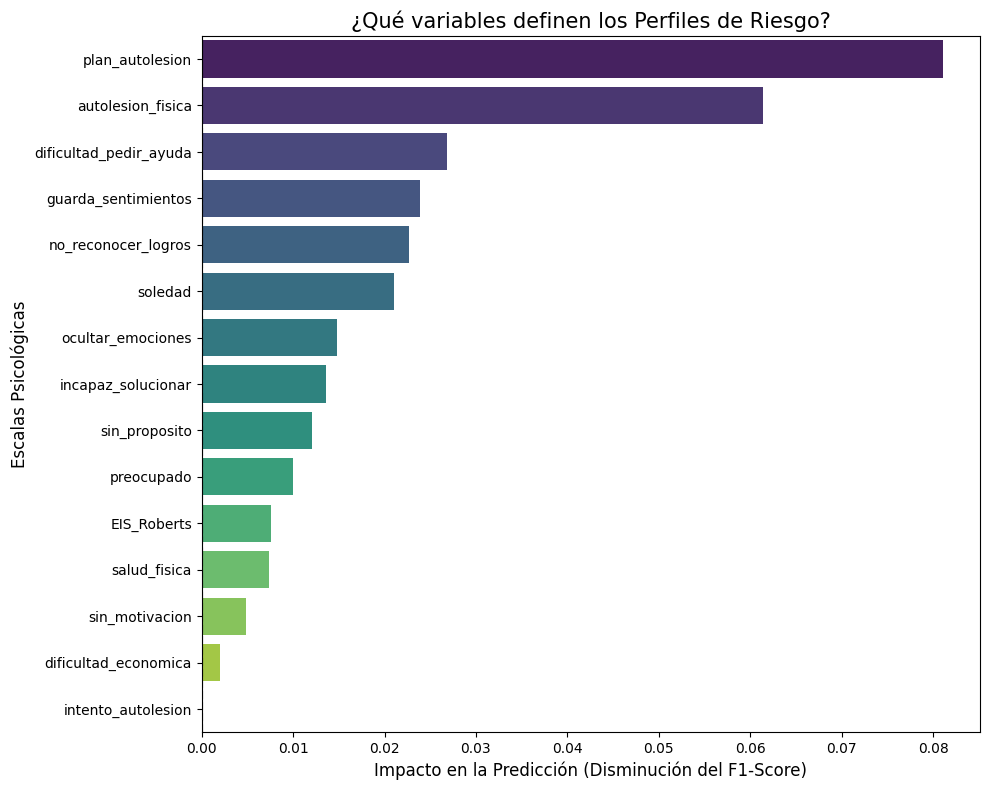


--- RANKING DE VARIABLES ---
              Variable  Importancia       SD
       plan_autolesion     0.081082 0.025022
     autolesion_fisica     0.061421 0.014604
dificultad_pedir_ayuda     0.026837 0.009775
   guarda_sentimientos     0.023906 0.006594
   no_reconocer_logros     0.022693 0.007351
               soledad     0.021060 0.007540
     ocultar_emociones     0.014853 0.006471
    incapaz_solucionar     0.013616 0.008215
         sin_proposito     0.012022 0.008134
            preocupado     0.010031 0.007623
           EIS_Roberts     0.007570 0.004682
          salud_fisica     0.007356 0.003604
        sin_motivacion     0.004897 0.006821
  dificultad_economica     0.002019 0.003431
    intento_autolesion     0.000000 0.000000


In [17]:
print("Analizando importancia de variables...")
result = permutation_importance(
    best_model, X, y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro'
)

importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': result.importances_mean,
    'SD': result.importances_std
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Variable', data=importancia, palette='viridis')
plt.title('¿Qué variables definen los Perfiles de Riesgo?', fontsize=15)
plt.xlabel('Impacto en la Predicción (Disminución del F1-Score)', fontsize=12)
plt.ylabel('Escalas Psicológicas', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

print("\n--- RANKING DE VARIABLES ---")
print(importancia.to_string(index=False))

# PCA

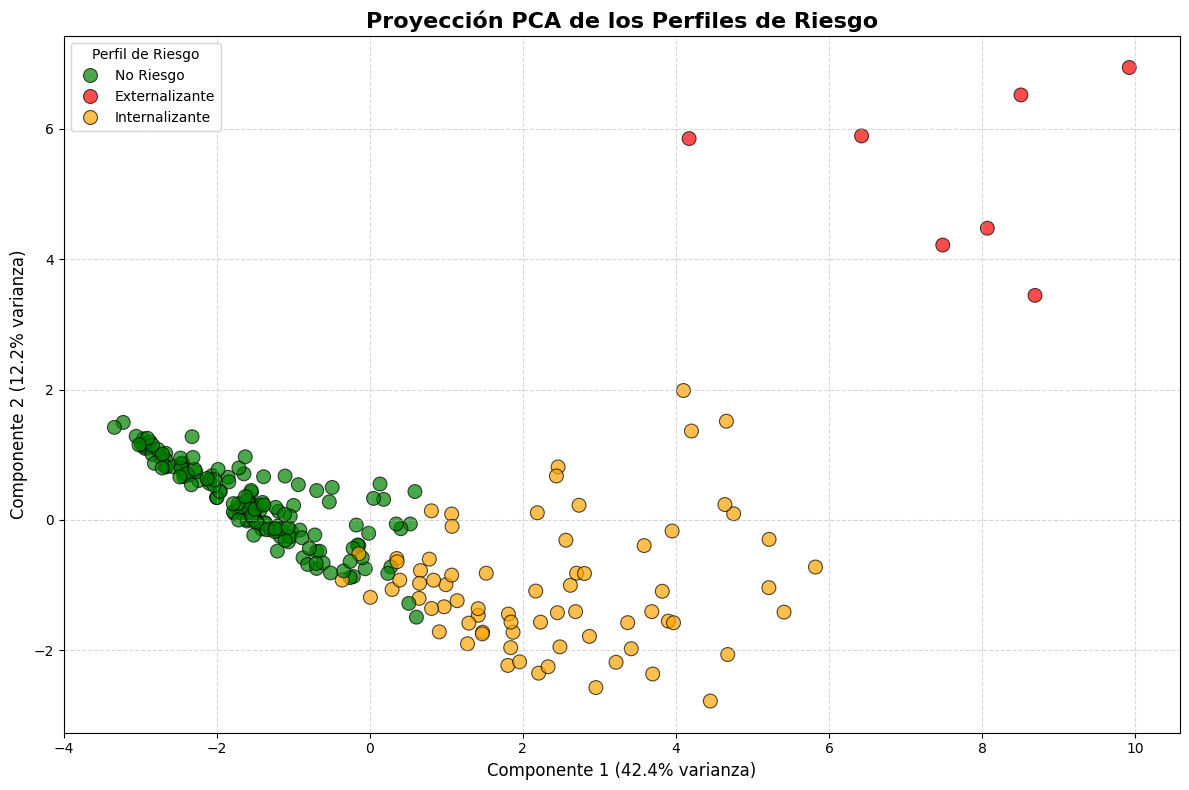

In [20]:
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principalComponents, columns=['Componente 1', 'Componente 2'])
pca_df['Cluster'] = y.values
pca_df['Cluster_Nombre'] = pca_df['Cluster'].map(
    {0: 'No Riesgo', 1: 'Internalizante', 2: 'Externalizante'}
)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Componente 1', y='Componente 2',
    hue='Cluster_Nombre', data=pca_df,
    palette={'No Riesgo': 'green', 'Internalizante': 'orange', 'Externalizante': 'red'},
    s=100, alpha=0.7, edgecolor='black'
)
plt.title('Proyección PCA de los Perfiles de Riesgo', fontsize=16, fontweight='bold')
plt.xlabel(f'Componente 1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)', fontsize=12)
plt.ylabel(f'Componente 2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)', fontsize=12)
plt.legend(title='Perfil de Riesgo')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Guardar el modelo

In [21]:
# Guardar modelo
carpeta_destino = '/content/drive/MyDrive/Trabajo_final_promidat/'
ruta_completa = os.path.join(carpeta_destino, 'Modelo_SUICIDIO_FINAL_2_ESTE_ES.pkl')
joblib.dump(best_model, ruta_completa)
print(f"Modelo guardado en: {ruta_completa}")



Modelo guardado en: /content/drive/MyDrive/Trabajo_final_promidat/Modelo_SUICIDIO_FINAL_2_ESTE_ES.pkl


# Pacientes Nuevos

In [22]:
# Pacientes ficticios
cols_ordenadas = [
    "EIS_Roberts", "salud_fisica", "ocultar_emociones",
    "dificultad_pedir_ayuda", "guarda_sentimientos", "sin_motivacion",
    "preocupado", "sin_proposito", "no_reconocer_logros",
    "incapaz_solucionar", "intento_autolesion", "plan_autolesion",
    "autolesion_fisica", "soledad", "dificultad_economica"
]

pacientes = [
    [11, 4, 6, 6, 6, 6, 6, 6, 5, 6, 4, 6, 5, 6, 5],
    [4, 4, 5, 4, 5, 5, 5, 4, 4, 4, 0, 0, 0, 5, 2],
    [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]
]

df_nuevos = pd.DataFrame(pacientes, columns=cols_ordenadas)
prediccion = best_model.predict(df_nuevos)
probabilidades = best_model.predict_proba(df_nuevos)

mapa_dx = {0: "No Riesgo", 1: "Internalizante", 2: "Externalizante"}

for i, nombre in enumerate(["Julián (Grave)", "Andrés (Silencioso)", "Carlos (Sano)"]):
    probs = probabilidades[i] * 100
    print(f"\nPaciente: {nombre}")
    print(f"  Clasificación: {mapa_dx[prediccion[i]]}")
    print(f"  P(No Riesgo): {probs[0]:.1f}% | P(Int): {probs[1]:.1f}% | P(Ext): {probs[2]:.1f}%")


Paciente: Julián (Grave)
  Clasificación: Externalizante
  P(No Riesgo): 0.8% | P(Int): 1.2% | P(Ext): 98.0%

Paciente: Andrés (Silencioso)
  Clasificación: Internalizante
  P(No Riesgo): 0.0% | P(Int): 99.4% | P(Ext): 0.6%

Paciente: Carlos (Sano)
  Clasificación: No Riesgo
  P(No Riesgo): 99.8% | P(Int): 0.0% | P(Ext): 0.2%


In [23]:
nested_scores['test_score'].mean()

np.float64(0.9259612878321272)

In [24]:
# Ver qué tan variable es el desempeño entre folds externos
print("Scores por fold externo:")
for i, score in enumerate(nested_scores['test_score']):
    print(f"  Fold {i+1}: {score:.4f}")

Scores por fold externo:
  Fold 1: 0.9477
  Fold 2: 0.9693
  Fold 3: 0.9477
  Fold 4: 0.9686
  Fold 5: 0.8443
  Fold 6: 0.9686
  Fold 7: 0.9498
  Fold 8: 0.9586
  Fold 9: 0.9392
  Fold 10: 0.9602
  Fold 11: 0.9686
  Fold 12: 0.8543
  Fold 13: 0.9686
  Fold 14: 0.9586
  Fold 15: 0.9895
  Fold 16: 0.9161
  Fold 17: 0.9036
  Fold 18: 0.9797
  Fold 19: 0.8852
  Fold 20: 0.9477
  Fold 21: 0.9594
  Fold 22: 0.8480
  Fold 23: 0.8461
  Fold 24: 0.8519
  Fold 25: 0.9161
  Fold 26: 0.9686
  Fold 27: 0.9602
  Fold 28: 0.7903
  Fold 29: 0.8519
  Fold 30: 0.9602


In [25]:
nested_scores['test_score'].std()

np.float64(0.05253505831417513)

# Último intento